In [1]:
import numpy as np
from scipy.misc import imresize
import matplotlib.pyplot as plt
import itertools
from skimage import filters
from skimage import morphology
from skimage import exposure

def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

In [2]:
data = np.load('train.npy')

train_samples = data[:125000, 0]
train_labels = data[:125000, 1]
test_samples = data[125000:, 0]
test_labels = data[125000:, 1]
del data

In [3]:
IMG_ROWS = 80
IMG_COLUMNS = 70
rescaled_train_samples = train_samples.copy()
rescaled_test_samples = test_samples.copy()
for i in log_progress(range(rescaled_train_samples.shape[0]), every=10):
    img = imresize(rescaled_train_samples[i], (IMG_ROWS, IMG_COLUMNS), interp='lanczos')
    img = img.astype('float32')
    img /= 255.0
    filter_blurred_f = filters.gaussian(img, 1)
    alpha = 1
    rescaled_train_samples[i] = img + alpha * (img - filter_blurred_f)
for i in log_progress(range(rescaled_test_samples.shape[0]), every=10):
    img = imresize(rescaled_test_samples[i], (IMG_ROWS, IMG_COLUMNS), interp='lanczos')
    img = img.astype('float32')
    img /= 255.0
    filter_blurred_f = filters.gaussian(img, 1)
    alpha = 1
    rescaled_test_samples[i] = img + alpha * (img - filter_blurred_f)

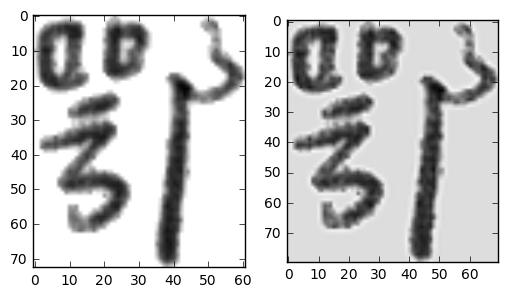

In [ ]:
plt.subplot(121)
plt.imshow(train_samples[2], cmap='gray')
plt.subplot(122)
plt.imshow(rescaled_train_samples[2], cmap='gray')
plt.show()

In [ ]:
train_samples = np.dstack(rescaled_train_samples).transpose((2, 0, 1))
test_samples = np.dstack(rescaled_test_samples).transpose((2, 0, 1))

np.save('train_samples.npy', train_samples)
np.save('train_labels.npy', train_labels)
np.save('test_samples.npy', test_samples)
np.save('test_labels.npy', test_labels)

## CNN

In [ ]:
train_samples = np.load('train_samples.npy')
train_labels = np.load('train_labels.npy')
test_samples = np.load('test_samples.npy')
test_labels = np.load('test_labels.npy')

In [ ]:
minLabel = np.min(train_labels)
maxLabel = np.max(train_labels)
print('range from', minLabel, 'to', maxLabel)
sorted_labels = sorted(train_labels.tolist())
unique_labels = []
for k, g in itertools.groupby(sorted_labels):
    unique_labels.append(k)
print(len(unique_labels), 'unique labels')

labels_to_indices = dict()
indices_to_labels = dict()
for i in range(len(unique_labels)):
    labels_to_indices[unique_labels[i]] = i
    indices_to_labels[i] = unique_labels[i]

new_train_labels = np.vectorize(lambda x: labels_to_indices[x])(train_labels)
new_test_labels = np.vectorize(lambda x: labels_to_indices[x])(test_labels)

In [ ]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

np.random.seed(1337)

if K.image_dim_ordering() == 'th':
    train_samples = train_samples.reshape(train_samples.shape[0], 1, IMG_ROWS, IMG_COLUMNS)
    test_samples = test_samples.reshape(test_samples.shape[0], 1, IMG_ROWS, IMG_COLUMNS)
    input_shape = (1, IMG_ROWS, IMG_COLUMNS)
else:
    train_samples = train_samples.reshape(train_samples.shape[0], IMG_ROWS, IMG_COLUMNS, 1)
    test_samples = test_samples.reshape(test_samples.shape[0], IMG_ROWS, IMG_COLUMNS, 1)
    input_shape = (IMG_ROWS, IMG_COLUMNS, 1)

batch_size = 256
nb_classes = len(unique_labels)
nb_epoch = 20

# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (5, 5)

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(new_train_labels, nb_classes)
Y_test = np_utils.to_categorical(new_test_labels, nb_classes)

model = Sequential()

model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                        border_mode='valid',
                        input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.fit(train_samples, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(test_samples, Y_test))
score = model.evaluate(test_samples, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
